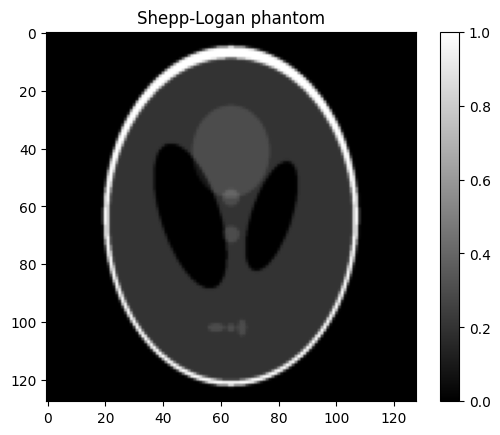

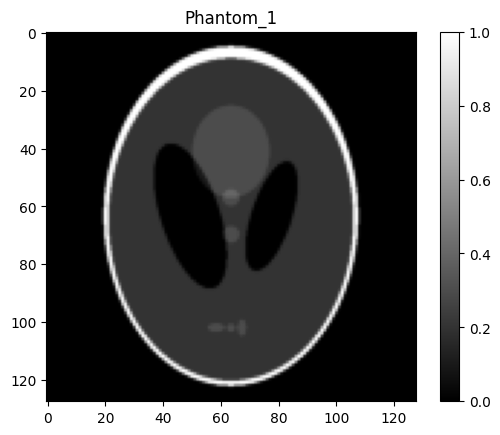

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fft import fftshift, fft2, ifft2
from skimage.data import shepp_logan_phantom # type: ignore
from skimage.transform import resize
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from tqdm import tqdm

# Re-generate and resize Shepp-Logan phantom
N_spinsx = 128  # Number of spins in each direction
N_spinsy = 128  # Number of spins in each direction
phantom = shepp_logan_phantom()
phantom = resize(phantom, (N_spinsx, N_spinsy))

# Plot Shepp-Logan phantom
plt.imshow(np.abs(phantom), cmap='gray')
plt.title('Shepp-Logan phantom')
plt.colorbar()
plt.show()


# K-space size
Nx = 128
Ny = 128

phantom_1 = resize(phantom, (Nx, Ny))

phantom = phantom.astype(dtype=np.complex128)
phantom_1 = phantom_1.astype(dtype=np.complex128)


# Plot the phantom_1
plt.imshow(np.abs(phantom_1), cmap='gray')
plt.title('Phantom_1')
plt.colorbar()
plt.show()




gamma = 42.58e6  # Gyromagnetic ratio for hydrogen in Hz/T
g_mult = 10 # Gradient multiplication factor
Gx = 0.004755753 * g_mult  # Gradient strength in T/m
Gy = 0.004755753 * g_mult # Gradient strength in T/m
#B0 = 1.0  # B0 field in T

In [10]:


# Field of view
FOV = 0.2  # meters

# Time intervals for the gradients
tau = 2e-3
timex = np.linspace(-tau/2, tau/2, Nx)
timey = np.linspace(-tau/2, tau/2, Ny)

# Gradient fields
Gx_values = timex * Gx
Gy_values = timey * Gy

# k-space trajectory (spatial frequencies)
kx_values_even = gamma * Gx_values[::2]
kx_values_odd = gamma * Gx_values[1::2]

ky_values_even = gamma * Gy_values
ky_values_odd = gamma * Gy_values

# Spatial coordinates
x_values = np.linspace(-FOV / 2, FOV / 2, Nx)
y_values = np.linspace(-FOV / 2, FOV / 2, Ny)
x_values, y_values = np.meshgrid(x_values, y_values, indexing='ij')

# Flatten the phantom
phantom_flat_1 = phantom_1.flatten()

# Flatten the arrays to make them 1D
x_values_flat = x_values.flatten()
y_values_flat = y_values.flatten()

#Allocate memory for flattened k-space
k_space_flat = np.zeros(Nx*Ny, dtype=np.complex128)
k_space_flat_1 = np.zeros(Nx*Ny, dtype=np.complex128)



# Iterate through the kx and ky values
iterator = 0
for i, kx in tqdm(enumerate(kx_values_even)):
    for j, ky in enumerate(ky_values_even):
        # Calculate the k-space value for this (kx, ky) point
        k_space_flat[iterator] = np.sum(phantom_flat_1 * np.exp(-1j * (kx * x_values_flat + ky * y_values_flat)))
        iterator += 1

iterator = 0
for i, kx in tqdm(enumerate(kx_values_even)):
    for j, ky in enumerate(ky_values_odd):
        # Calculate the k-space value for this (kx, ky) point
        k_space_flat_1[iterator] = np.sum(phantom_flat_1 * np.exp(-1j * (kx * x_values_flat + ky * y_values_flat)))
        iterator += 1


# Reshape the flattened k-space data back into 2D matrix form
k_space = np.reshape(k_space_flat, (Nx, Ny))

# Initialize the output array
True_kspace_interlinked = np.zeros((Nx*Ny,), dtype=np.complex128)

# Assign the even and odd k-space vectors to the interlinked array
True_kspace_interlinked[::2] = k_space_flat
True_kspace_interlinked[1::2] = k_space_flat_1


# Plot the absolute k-space signal
plt.figure()
plt.imshow(np.abs(k_space), cmap='gray')
plt.title('K-space signal')
plt.colorbar()
plt.show()

# Plot the interlinked k-space signal
plt.figure()
plt.imshow(np.abs(True_kspace_interlinked), cmap='gray')
plt.title('Interlinked k-space signal')
plt.colorbar()
plt.show()


# Apply inverse FFT
reconstructed_image = ifft2(k_space)
reconstructed_image_1 = fftshift(reconstructed_image)

# Plot the reconstructed image
plt.figure()
plt.imshow(np.abs(reconstructed_image_1), cmap='gray')
plt.title('Recon image')
plt.colorbar()
plt.show()

0it [00:00, ?it/s]

64it [00:06,  9.82it/s]
64it [00:04, 13.76it/s]


ValueError: could not broadcast input array from shape (16384,) into shape (8192,)

In [8]:
E = np.zeros((Nx*Ny, Nx*Nx), dtype=np.complex128)
E_1 = np.zeros((Nx*Ny, Nx*Nx), dtype=np.complex128)


iterator = 0
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values_even):
        # Use the flattened arrays in the calculation
        E[:, iterator] = np.exp(-1j * (kx * x_values_flat + ky * y_values_flat))
        iterator += 1


iterator = 0
for i, kx in tqdm(enumerate(kx_values)):
    for j, ky in enumerate(ky_values_odd):
        # Use the flattened arrays in the calculation
        E_1[:, iterator] = np.exp(-1j * (kx * x_values_flat + ky * y_values_flat))
        iterator += 1

TrueE = np.vstack((E, E_1))


5it [00:00,  8.14it/s]


KeyboardInterrupt: 

In [ ]:
x, istop, itn, r1norm, r2norm, anorm, acond, arnorm, xnorm, var = lsqr(TrueE, True_kspace, iter_lim=200, show=True)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 32768 rows and 16384 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =      200
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   3.733e+03  3.733e+03    1.0e+00  2.4e-02


KeyboardInterrupt: 

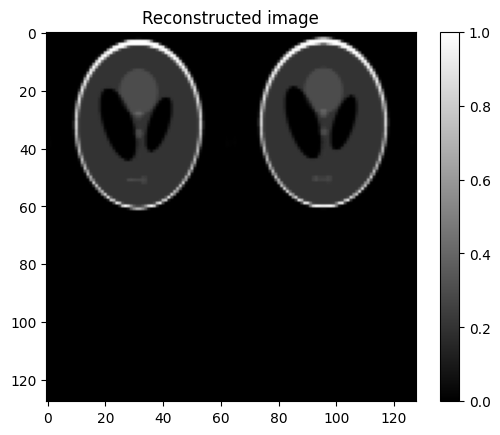

In [ ]:
image = np.reshape(x, (Nx, Nx))

# Plot the image
plt.figure()
plt.imshow(np.abs(image), cmap='gray')
plt.title('Reconstructed image')
plt.colorbar()
plt.show()